# Understanding image field shift during lens movements in a Scheimpflug camera

It is well-known that the center of perspective projection of a lens is the center of the entrance pupil. This essentially means that the chief-rays from various points of a plane that is in sharp focus will (appear to) intersect the optical axis at the center of the entrance pupil, forming the vertex of the projection cone at the input (object) side.

Since the entrance pupil, the limiting aperture and the exit pupil are images of each other, the chief-rays also (physically) intersect the optical axis at the center of the limiting aperture, and then (appear to) intersect at the center of exit pupil before forming the image. Thus, the center of the exit pupil forms the vertex of the projection cone at the output (image) side. In other words, the center of the exit pupil is the center of projection of the image. 

First we will study, using geometric optics, the center of perspective projection of a lens, and of the image, and the consequences of rotating a lens about a point away from or coinciding with the center of projection. We will study the entrance pupil and exit pupil for two lenses -- a Double Gauss 28 degrees FOV lens (representative of real lenses) and a lens created using paraxial surfaces (ideal lens) to understand the role of aberrations.

In [1]:
from __future__ import print_function, division
import numpy as np
import os as os
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
import iutils.opticsutils.imager as imgr
import matplotlib.pyplot as plt
%matplotlib inline

Helper function for saving figures

In [3]:
bSaveFigure = False
dir2saveFig = r"C:\Users\Indranil\Dropbox\Indranil_PHD_Resources\Publications\opticslet\figures\\"
fig_format = 'png'
fig_ext = '.png'

def saveFigure(figure, fig_name, DPI=72):
    if bSaveFigure:
        figure.savefig(dir2saveFig + fig_name + fig_ext,
                    dpi=DPI,  # This will change the number of pixels in the image
                    facecolor='white', edgecolor='white',
                    #transparent=True, # for transparency to work, the facecolor can't be used.
                    bbox_inches='tight',
                    format=fig_format, pad_inches=0.03)

In [4]:
ln = pyz.createLink()

# Location of the Zemax lens files for this notebook
# The lens design files in this directory were tweeked to 
# use a single wavelength of 0.55 microns, have fields defined
# at 0, -5, +5, -10, 10, -15 and +15 degrees
zmxdir = os.path.join(os.getcwd(), "zmxfiles")

The following helper functions shall be used to insert the cardinal and pupil planes (represented as surfaces) in the Zemax LDE. 

In [5]:
# Helper functions to draw the cardinal and pupil planes

def draw_plane(ln, space='img', dist=0, surfName=None):
    """function to draw planes at the points specified by "dist"
    
    Parameters
    ----------
    ln : pyzdde object
        active link object
    space : string, optional
        Image space or object space in which the plane is 
        specified. 'img' for image space, 'obj' for object space
    dist : float, optional
        distance of the plane from the 1st surface if space in object
        space or from the IMG surface if image space along the optical 
        axis
    surfName : string, optional
        a name to identify the surface in the LDE. This name is added
        to the comments column
        
    Returns
    -------
    None
    
    Assumption
    ----------
    The function assumes (for the purpose of this study) that 
    surface 1 is a dummy surface for rendering rays. So the function
    inserts the planes (and their associated dummy surfaces) at 
    surface 2.
    """
    numSurf = ln.zGetNumSurf()
    inSurfPos = numSurf if space=='img' else 2 # assuming that the first surface will be a dummy surface
    ln.zInsertSurface(inSurfPos)
    comment, thickness, ignoreSurface = 1, 3, 20
    ln.zSetSurfaceData(inSurfPos, comment, 'dummy')
    ln.zSetSurfaceData(inSurfPos, thickness, dist)
    #ln.zSetSurfaceData(inSurfPos, ignoreSurface, 1) # can't use this because the thickness will be ignored.
    ln.zInsertSurface(inSurfPos+1)
    ln.zSetSurfaceData(inSurfPos+1, comment, surfName)
    thickSolve, pickupSolve = 1, 5
    frmSurf, scale, offset, col = inSurfPos, -1, 0, 0
    ln.zSetSolve(inSurfPos+1, thickSolve, pickupSolve, frmSurf, scale, offset, col)

def get_cardinal_points(ln, firstDummySurfOff):
    """returns the distances of the cardinal points (along the optical axis)
    
    Parameters
    ----------
    ln : object
        PyZDDE object
    firstDummySurfOff : float
        the thickness of the dummy surface, which is generally the
        surface 1. See the notes
    
    Returns
    -------
    fpObj : float
        distance of object side focal point from surface 2 (assuming surface)
        1 is dummy
    fpImg : float
        distance of image side focal point from IMG surface
    ppObj : float
        distance of the object side principal plane from surface 2
    ppImg : float
        distance of the image side principal plane from IMG
    
    
    Notes
    -----
    The "dummy surface" referred to in this function is particular to 
    this local study of cardinal points. The purpose of the dummy surface
    is to show the input rays to the left of the first surface, which
    becomes useful for rendering the input rays and the optical system 
    if the object is at infinity or very large.
    """
    textFileName = os.path.join(zmxdir, "tmp.txt")
    sysProp = ln.zGetSystem()
    numSurf = sysProp.numSurf
    # Since the object space cardinal points are reported w.r.t. the 
    # surface 1, ensure that surface 1 is global reference surface 
    if sysProp.globalRefSurf is not 1: 
        ln.zSetSystem(unitCode=sysProp.unitCode, stopSurf=sysProp.stopSurf, 
                      rayAimingType=sysProp.rayAimingType, temp=sysProp.temp, 
                      pressure=sysProp.pressure, globalRefSurf=1)
    ln.zGetTextFile(textFileName, 'Pre', "None", 0)
    line_list = pyz._readLinesFromFile(pyz._openFile(textFileName))
    ppObj, ppImg, fpObj, fpImg = 0.0, 0.0, 0.0, 0.0
    count = 0
    for line_num, line in enumerate(line_list):
        # Extract the Focal plane distances
        if "Focal Planes" in line:
            fpObj += float(line.split()[3])
            fpImg += float(line.split()[4])
        # Extract the Principal plane distances.
        if "Principal Planes" in line and "Anti" not in line:
            ppObj += float(line.split()[3])
            ppImg += float(line.split()[4])
            count +=1  #Increment (wavelength) counter for averaging
    # Calculate the average (for all wavelengths) of the principal plane distances
    # This is only there for extracting a single point ... ideally the design
    # should have just one wavelength define!
    if count > 0:
        fpObj = fpObj/count
        fpImg = fpImg/count
        ppObj = ppObj/count
        ppImg = ppImg/count
    if sysProp.globalRefSurf is not 1:
        ln.zSetSystem(unitCode=sysProp.unitCode, stopSurf=sysProp.stopSurf, 
                      rayAimingType=sysProp.rayAimingType, temp=sysProp.temp, 
                      pressure=sysProp.pressure, 
                      globalRefSurf=sysProp.globalRefSurf)
    # Delete the temporary file
    pyz._deleteFile(textFileName)
    return fpObj - firstDummySurfOff, fpImg, ppObj - firstDummySurfOff, ppImg
      
def draw_pupil_cardianl_planes(ln, firstDummySurfOff=40, push=True):
    """function to insert the pupil and cardianl planes in the
    LDE. The layout will show the surfaces
    
    Parameters
    ----------
    ln : object
        the PyZDDE object
    firstDummySurfOff : float
        the thickness of the first dummy surface (see notes in the
        docstring of ``get_cardinal_points()``)
    push : bool
        push lens in the DDE server to the LDE
        
    Assumptions
    -----------
    The function assumes that the lens is already focused appropriately,
    for either finite or infinite conjugate imaging. 
    
    Notes
    -----
    The cardinal and pupil planes are draws using standard surfaces
    in the LDE. In order to ensure that the ray tracing engine does
    not treat these surfaces as real surfaces, we have to instruct
    Zemax to "ignore" rays to these surfaces. Also, for clarity, the
    dummy sufaces may also be ignored for drawing. Unfortunately, doing 
    this is not possible programmatically; So, after the planes have
    been drawn, we need to manually do the following:
    
    1. 2D Layout settings
        a. Set number of rays to 1 or as needed
    2. For all dummy surfaces except the dummy surface 1, 
       go to "Surface Properties" >> "Draw" tab
        a. Select "Skip rays to this surface"
        b. Select "Do not draw this surface"
    3. For dummy surface 1, select "Do not draw this surface"
    4. For the pupil and cardinal surfaces, 
       go to "Surface Properties" >> Draw tab
        a. Select Skip rays to this surface (if required)
    5. Set field points to be symmetric about the optical axis
    """
    ln.zSetWave(0, 1, 1)
    ln.zSetWave(1, 0.55, 1)
    # insert dummy surface at 1 for showing the input ray
    ln.zRemoveVariables()
    ln.zInsertSurface(1)
    comment, thickness, thickVal = 1, 3, firstDummySurfOff
    ln.zSetSurfaceData(1, thickness, thickVal)
    ln.zSetSurfaceData(1, comment, 'dummy for ray visibility')
    origImgSurfNum = ln.zGetNumSurf()
    
    # Draw Exit and entrance pupil planes
    expp = ln.zGetPupil().EXPP
    print("Exit pupil distance from IMG:", expp)
    draw_plane(ln, 'img', expp, "EXPP")
    
    enpp = ln.zGetPupil().ENPP
    print("Entrance pupil from Surf 1:", enpp)
    draw_plane(ln, 'obj', enpp, "ENPP")

    # Get and draw the principal Planes
    fpObj, fpImg, ppObj, ppImg = get_cardinal_points(ln, firstDummySurfOff)
    print("Focal plane obj: ", fpObj, "\nFocal plane img: ", fpImg)
    draw_plane(ln,'img', fpImg, "Focal Img space")
    draw_plane(ln,'obj', fpObj, "Focal Obj space")
    print("Principal plane obj: ", ppObj, "\nPrincipal plane img: ", ppImg)
    draw_plane(ln,'img', ppImg, "Principal Img space")
    draw_plane(ln,'obj', ppObj, "Principal Obj space")

    # Check the validity of the distances
    ppObjToEnpp = ppObj - enpp
    ppImgToExpp = ppImg - expp
    focal = ln.zGetFirst().EFL
    print("Focal length: ", focal)
    print("Principal plane H to ENPP: ", ppObjToEnpp)
    print("Principal plane H' to EXPP: ", ppImgToExpp)
    v = imgr.gaussian_lens_formula(u=ppObjToEnpp, v=None, f=focal)
    print("Principal plane H' to EXPP (absolute distance) "
          "calculated using lens equation: ", abs(v))
    ppObjTofpObj = ppObj - fpObj
    ppImgTofpImg = ppImg - fpImg
    print("Principal plane H to rear focal plane: ", ppObjTofpObj)
    print("Principal plane H' to front focal plane: ", ppImgTofpImg)
    if push:
        ln.zPushLens(1)

## Entrance and exit pupil as center of projections for a non-ideal lens

Our first lens to try is the Double Gauss 28 degrees FOV, which is shipped with Zemax. It is an example of a non-ideal lens (i.e. it has some amount of aberration). After loading the lens into Zemax, the function ``draw_pupil_cardinal_planes()`` is called. The function inserts the pupil planes and cardianl planes into the LDE and outputs the same information as text. 

The following output is the case when the lens is focused at infinity.

In [6]:
lens = "Double Gauss 28 degree field.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)
draw_pupil_cardianl_planes(ln, 0)

Exit pupil distance from IMG: -108.123923
Entrance pupil from Surf 1: 59.00145359
Focal plane obj:  -32.427065 
Focal plane img:  0.169759
Principal plane obj:  67.07736 
Principal plane img:  -99.334666
Focal length:  99.50442486
Principal plane H to ENPP:  8.07590641
Principal plane H' to EXPP:  8.789257
Principal plane H' to EXPP (absolute distance) calculated using lens equation:  8.7892534646
Principal plane H to rear focal plane:  99.504425
Principal plane H' to front focal plane:  -99.504425


In [7]:
# For drawing the figure, we can use a stored copy in order to avoid
# manually changing surface properties in the LDE
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "Double Gauss 28 degree field_CardinalsDrawn_focusedAtInfinity.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()
lay_arr = ln.ipzCaptureWindow('Lay', percent=20, gamma=0.15, retArr=True)

The layout plot with the 

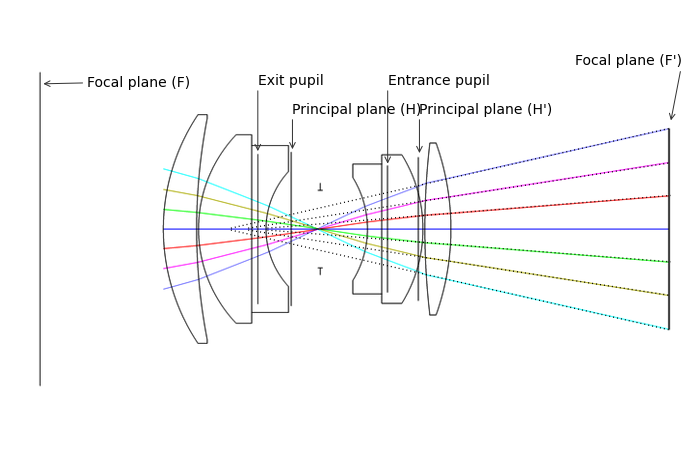

In [8]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
pyz.imshow(lay_arr, cropBorderPixels=(2, 15, 40, 40), fig=fig, faxes=ax)
ax.annotate("Focal plane (F)", (35, 80), (82, 82), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(0.5,0.5)))
ax.annotate("Focal plane (F')", (689, 120), (590, 60), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(1.0,0.0)))
ax.annotate("Entrance pupil", (395, 165), (395, 80), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(0.0,1.0)))
ax.annotate("Exit pupil", (260, 152), (260, 80), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H)", (296, 150), (296, 110), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H')", (428, 154), (428, 110), fontsize=14, color='k', 
            arrowprops=dict(arrowstyle="->", linewidth=1, relpos=(0.0,1.0)))
ax.plot([232, 689],[230, 126], ls='dotted', color='k')
ax.plot([232, 689],[232, 336], ls='dotted', color='k')
ax.plot([250, 689],[230, 162], ls='dotted', color='k')
ax.plot([250, 689],[232, 300], ls='dotted', color='k')
ax.plot([270, 689],[230, 196], ls='dotted', color='k')
ax.plot([270, 689],[232, 265], ls='dotted', color='k')
plt.show()

It can be seen from the above figure, that the rays exiting the last surface when extended backwards towards the optical axis does not meet at the center of the exit pupil. The rays that are symmetric about the optical axis meet at points along the optical axis, and it seems that the divergence of the point of intersection of these rays from the exit pupil increases with increase in the off-axis angle. Although, the point of intersection of the input rays is not clear from the above figure (because we can only see very small portions of each incoming ray before the first lens surface) they all do meet at the center of the entrance pupil, as it is shown next. 

Now in order to inspect the scenario when the lens is focused at a finite distance, we will use the same lens to image at finite conjugates, focusing at 500 mm from the first glass surface.

In [9]:
lens = "Double Gauss 28 degree field.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)
OBJ, thickness, thickVal = 0, 3, 500
ln.zSetSurfaceData(OBJ, thickness, thickVal)
ln.zQuickFocus()
ln.zPushLens(1)
# Visually ensure that the starting point is as expected.

0

In [10]:
draw_pupil_cardianl_planes(ln, 0)

Exit pupil distance from IMG: -128.4303967
Entrance pupil from Surf 1: 59.00145359
Focal plane obj:  -32.427065 
Focal plane img:  -20.136715
Principal plane obj:  67.07736 
Principal plane img:  -119.64114
Focal length:  99.50442486
Principal plane H to ENPP:  8.07590641
Principal plane H' to EXPP:  8.7892567
Principal plane H' to EXPP (absolute distance) calculated using lens equation:  8.7892534646
Principal plane H to rear focal plane:  99.504425
Principal plane H' to front focal plane:  -99.504425


In [11]:
%matplotlib inline

In [12]:
# For drawing the figure, we can use a stored copy in order to avoid
# manually changing surface properties in the LDE
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "Double Gauss 28 degree field_CardinalsDrawn_focusedAtFinite.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()
lay_arr = ln.ipzCaptureWindow('Lay', percent=50, gamma=0.32, retArr=True)

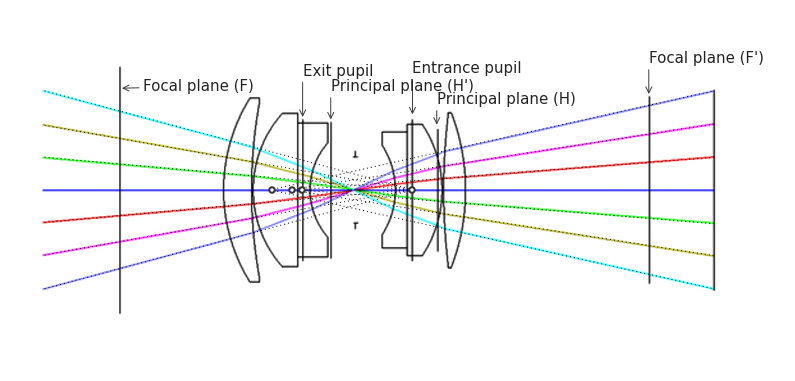

In [13]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

pyz.imshow(lay_arr, cropBorderPixels=(1200, 60, 550, 550), fig=fig, faxes=ax)

ax.annotate("Focal plane (F)", (60, 50), (78, 52), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.5,0.5)))
ax.annotate("Focal plane (F')", (474, 56), (474, 30), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Entrance pupil", (289, 72), (289, 38), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Exit pupil", (203, 74), (203, 40), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H)", (308, 80), (308, 62), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H')", (225, 76), (225, 52), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))

# lines for incoming rays
ax.plot([1, 291],[52, 130], ls='dotted', color='k', lw=1)
ax.plot([1, 291],[207, 129], ls='dotted', color='k', lw=1)
ax.plot([1, 291],[79, 130], ls='dotted', color='k', lw=1)
ax.plot([1, 291],[180.5, 129], ls='dotted', color='k', lw=1)
ax.plot([1, 291],[104, 130], ls='dotted', color='k', lw=1)
ax.plot([1, 291],[155, 129], ls='dotted', color='k', lw=1)

# point of intersection
ax.scatter([289,], [130,], s=30, c='w', lw=2, zorder=20)

#ax.plot([1, 291],[52, 130],  color='#34FFFF', lw=1)
#ax.plot([1, 291],[207, 129],  color='#8383FF', lw=1)
#ax.plot([1, 291],[79, 130],  color='r', lw=1)
#ax.plot([1, 291],[180.5, 129],  color='k', lw=1)
#ax.plot([1, 291],[104, 130],  color='k', lw=1)
#ax.plot([1, 291],[155, 129], color='k', lw=1)

# lines for exiting rays
ax.plot([180, 525],[129, 52], ls='dotted', color='k', lw=1)
ax.plot([180, 525],[130, 207], ls='dotted', color='k', lw=1)
ax.plot([196, 525],[129, 78], ls='dotted', color='k', lw=1)
ax.plot([196, 525],[130, 181], ls='dotted', color='k', lw=1)
ax.plot([206, 525],[129, 104], ls='dotted', color='k', lw=1)
ax.plot([206, 525],[130, 156], ls='dotted', color='k', lw=1)

# points of intersection
ax.scatter([179, 195, 202.5], [130, 130, 130], s=30, c='w', lw=2, zorder=20)

#ax.plot([180, 525],[129, 52],  color='#8383FF', lw=1)
#ax.plot([180, 525],[130, 207], color='#34FFFF', lw=1)
#ax.plot([196, 525],[129, 78], color='#FF34FF', lw=1)
#ax.plot([196, 525],[130, 181], color='#BDBD46', lw=1)
#ax.plot([206, 525],[129, 104], color='#FF2222', lw=1)
#ax.plot([206, 525],[130, 156], color='#57FF57', lw=1)


# Save figure, if turned on
saveFigure(fig, fig_name = 'cop_and_image_projection_cone_reallens', DPI=200)

plt.show()

From the above figure we see that as before the extension of the rays to the image plane does not insersect at a common point. However, the incoming rays do appear to meet at the center of the entrance pupil. 

The most likely reason for the exiting rays not meeting at the center of the exit pupil is the presence of aberration in the lens that deviates the chief-rays from the non-aberrated path.

In order to confirm this suspicion, we will examine a lens system with no aberrations -- in which the surfaces are paraxial surfaces.

#### For the paraxial lens

In [14]:
lens = "paraxialDoubleLens2.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)
draw_pupil_cardianl_planes(ln, 40)

Exit pupil distance from IMG: -52.29967208
Entrance pupil from Surf 1: 14.48275862
Focal plane obj:  -17.311828 
Focal plane img:  -7.752821
Principal plane obj:  20.322581 
Principal plane img:  -45.38723
Focal length:  37.6344086
Principal plane H to ENPP:  5.83982238
Principal plane H' to EXPP:  6.91244208
Principal plane H' to EXPP (absolute distance) calculated using lens equation:  6.91244289451
Principal plane H to rear focal plane:  37.634409
Principal plane H' to front focal plane:  -37.634409


In [15]:
# For drawing the figure, we can use a stored copy in order to avoid
# manually changing surface properties in the LDE
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens2_CardinalsDrawn.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()
lay_arr = ln.ipzCaptureWindow('Lay', percent=60, gamma=0.5, retArr=True)

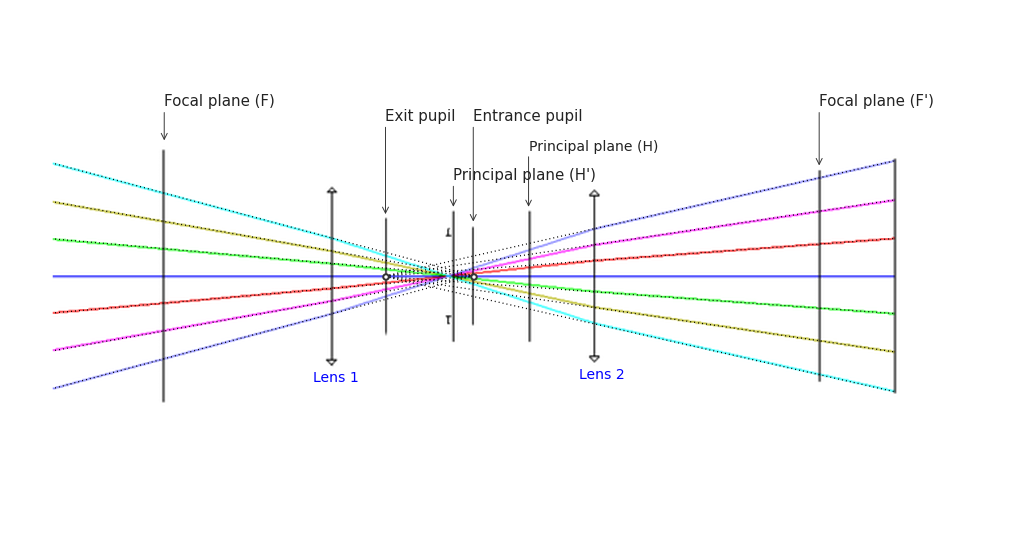

In [16]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
pyz.imshow(lay_arr, cropBorderPixels=(1500, 60, 650, 650), fig=fig, faxes=ax)
ax.annotate("Focal plane (F)", (75, 75), (75, 50), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Focal plane (F')", (519, 92), (519, 50), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Entrance pupil", (284.5, 130), (284.5, 60), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Exit pupil", (225, 125), (225, 60), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H)", (322, 120), (322, 80), fontsize=14, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.annotate("Principal plane (H')", (271, 120), (271, 100), fontsize=15, color='#222222', 
            arrowprops=dict(arrowstyle="->", linewidth=0.95, relpos=(0.0,1.0)))
ax.text(176, 237, 'Lens 1', fontsize=14, color='blue')
ax.text(356, 235, 'Lens 2', fontsize=14, color='blue')

# lines for incoming rays
ax.plot([1, 284.5],[89.5, 165.5], ls='dotted', color='k')
ax.plot([1, 284.5],[241.5, 165.5], ls='dotted', color='k')
ax.plot([1, 284.5],[115.5, 165.5], ls='dotted', color='k')
ax.plot([1, 284.5],[216, 165.5], ls='dotted', color='k')
ax.plot([1, 284.5],[140.5, 165.5], ls='dotted', color='k')
ax.plot([1, 284.5],[190.5, 165.5], ls='dotted', color='k')

# points of intersection
ax.scatter([285,], [166,], s=30, c='w', lw=2, zorder=20)

# lines for outgoing rays
ax.plot([225, 570],[165.5, 87.5], ls='dotted', color='k')
ax.plot([225, 570],[166, 244], ls='dotted', color='k')
ax.plot([225, 570],[165.5, 114], ls='dotted', color='k')
ax.plot([225, 570],[166, 217], ls='dotted', color='k')
ax.plot([225, 570],[165.5, 140.2], ls='dotted', color='k')
ax.plot([225, 570],[166, 191], ls='dotted', color='k')

# point of intersection
ax.scatter([225.5,], [166,], s=30, c='w', lw=2, zorder=20)

# Save figure, if turned on
saveFigure(fig, fig_name = 'cop_and_image_projection_cone_aberrationFreelens', DPI=200)

plt.show()

As the above figure shows, the exit pupil is the center of projection of the image.

In [17]:
ln.close()

Paraxial 180 mm double lens

In [8]:
lens = "paraxialDoubleLensF180mm_pMag0_82.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)
draw_pupil_cardianl_planes(ln, 0)

Exit pupil distance from IMG: -165.2985587
Entrance pupil from Surf 1: 98.82352941
Focal plane obj:  -120.0 
Focal plane img:  -17.234043
Principal plane obj:  60.0 
Principal plane img:  -197.234043
Focal length:  180.0
Principal plane H to ENPP:  -38.82352941
Principal plane H' to EXPP:  -31.9354843
Principal plane H' to EXPP (absolute distance) calculated using lens equation:  31.9354838698
Principal plane H to rear focal plane:  180.0
Principal plane H' to front focal plane:  -180.0


##Verification of equations that show the relationship b/w image and object coordinates for rotating lens abt ENPP, when pupil magnification is different from 1

In [1]:
from __future__ import print_function, division
import numpy as np
import os
import pyzdde.zdde as pyz
import iutils.math.general as mgu

In [2]:
ln = pyz.createLink()
lens = "paraxialDoubleLensF180mm_EnppExpp36_88mm_pMag0_82_TiltAbtENPP_wSensorShift.zmx"
zmxdir = os.path.join(os.getcwd(), "zmxfiles")
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)

0

######Verify heights using distances measured from Principal planes, $\alpha = 0$

Ensure that the configuration is set to 1

In [3]:
ln.zSetConfig(config=1)

(1, 3, 0)

In [4]:
ln.zGetConfig()

(1, 3, 4)

In [5]:
gObjPos = ln.zGetGlobalMatrix(surfNum=0).Zo
gHPos = ln.zGetGlobalMatrix(surfNum=5).Zo # Principal plane in object space
gHdashPos = ln.zGetGlobalMatrix(surfNum=18).Zo # Principal plane in Image space
gImaPos = ln.zGetGlobalMatrix(surfNum=22).Zo
uo = abs(gHPos - gObjPos)
ui = abs(gImaPos - gHdashPos)
y = ln.zGetSurfaceData(surfNum=0, code=ln.SDAT_SEMIDIA) # 400 mm # object height
ydash = -(ui/uo)*y # image height
print('ydash (estimated):', ydash)

# Data from ray trace
rtHx0Hy1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=0, hy=1, px=0, py=0) # verify image height using ray tracing
ydash_rt = rtHx0Hy1.y
print('ydash_rt (ray traced):', ydash_rt)

print("Exterme field points:")
print('rtHx0Hy1.x:', rtHx0Hy1.x)
print('rtHx0Hy1.y:', rtHx0Hy1.y)

rtHx1Hy0 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=1, hy=0, px=0, py=0)
print('rtHx1Hy0.x:', rtHx1Hy0.x)
print('rtHx1Hy0.y:', rtHx1Hy0.y)

rtHx1Hy1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=1, hy=1, px=0, py=0)
print('rtHx1Hy1.x:', rtHx1Hy1.x)
print('rtHx1Hy1.y:', rtHx1Hy1.y)


ydash (estimated): -38.2978724272
ydash_rt (ray traced): -38.2978723404
Exterme field points:
rtHx0Hy1.x: 0.0
rtHx0Hy1.y: -38.2978723404
rtHx1Hy0.x: -38.2978723404
rtHx1Hy0.y: 0.0
rtHx1Hy1.x: -38.2978723404
rtHx1Hy1.y: -38.2978723404


Perfect!!

######Verify numbers with distances measured from Entrance and Exit pupil, $\alpha=0$

In [6]:
gObjPos = ln.zGetGlobalMatrix(surfNum=0)  
gEnppPos = ln.zGetGlobalMatrix(surfNum=9)
z_o = gEnppPos.Zo - gObjPos.Zo  # ENPP to Object distance in ENPP coordinate frame

gImaPos = ln.zGetGlobalMatrix(surfNum=22)
gExppPos = ln.zGetGlobalMatrix(surfNum=14) 
#zdash_i = gImaPos - gExppPos # EXPP to IMA distance in EXPP coordinate frame, not required
zdash_o = gImaPos.Zo - gEnppPos.Zo # ENPP to IMA distance
d = abs(gEnppPos.Zo - gExppPos.Zo) # EXPP to ENPP distance 
mp = ln.zGetPupilMagnification()

y_o = ln.zGetSurfaceData(surfNum=0, code=ln.SDAT_SEMIDIA) # 400 mm
alphaL = -ln.zGetMulticon(config=1, row=2)[0] # 0.0  # my rotation convention for lens is opposite

#ydash_o = -(1.0/mp)*((zdash_o + d)/z_o)*y_o
ydash_o = (-((zdash_o + d*mgu.cosd(alphaL))*
              (y_o*(1.0 + mp*mgu.tand(alphaL)**2) + z_o*(1.0 - mp)*mgu.tand(alphaL))/
              (z_o*(mp + mgu.tand(alphaL)**2) + y_o*(1.0 - mp)*mgu.tand(alphaL))) - 
              d*mgu.sind(alphaL))

x_o = y_o # 400 mm

xdash_o = -(1.0/mp)*((zdash_o + d*mgu.cosd(alphaL))/z_o)*x_o


# Print
print('EXPP global pos, z:', gExppPos.Zo)
print('EXPP global pos, y:', gExppPos.Yo)
print('d.sin(alpha):', d*mgu.sind(alphaL))
print('EXPP <--> ENPP:', d)
print('y_o:', y_o)
print('z_o:', z_o)
print('zdash_o:', zdash_o)
print('ydash_o:', ydash_o)
print('xdash_o:', xdash_o)

EXPP global pos, z: 2061.935484
EXPP global pos, y: 0.0
d.sin(alpha): -0.0
EXPP <--> ENPP: 36.888045
y_o: 400.0
z_o: 2098.823529
zdash_o: 128.410514
ydash_o: -38.2978724198
xdash_o: -38.2978724198


Perfect!!

Now set the configuration to 2. In this configuration, the lens is rotated about the ENPP anti-clockwise by an angle of 20°, but the sensor plane is kept fixed.

In [7]:
ln.zSetConfig(config=2)

(2, 3, 0)

In [8]:
ln.zGetConfig()

(2, 3, 4)

In [9]:
ln.zGetUpdate()

0

In [10]:
# Data from ray trace for HY = 1
rtHx0Hy1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=0, hy=1, px=0, py=0) # verify image height using ray tracing
ydash_rt = rtHx0Hy1.y
print('ydash_rt:', ydash_rt)

print("Exterme field points:")
print('rtHx0Hy1.x:', rtHx0Hy1.x)
print('rtHx0Hy1.y:', rtHx0Hy1.y)

rtHxneg1Hy1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=-1, hy=1, px=0, py=0)
print('rtHx-1Hy1.x:', rtHxneg1Hy1.x)
print('rtHx-1Hy1.y:', rtHxneg1Hy1.y)

rtHx1Hy1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=1, hy=1, px=0, py=0)
print('rtHx1Hy1.x:', rtHx1Hy1.x)
print('rtHx1Hy1.y:', rtHx1Hy1.y)

ydash_rt: -59.1309877467
Exterme field points:
rtHx0Hy1.x: 0.0
rtHx0Hy1.y: -59.1309877467
rtHx-1Hy1.x: 36.3837948727
rtHx-1Hy1.y: -59.1309877467
rtHx1Hy1.x: -36.3837948727
rtHx1Hy1.y: -59.1309877467


In [12]:
alphaL = -ln.zGetMulticon(config=2, row=2)[0] # my rotation convention for lens is opposite
ydash_o = (-((zdash_o + d*mgu.cosd(alphaL))*
              (y_o*(1.0 + mp*mgu.tand(alphaL)**2) + z_o*(1.0 - mp)*mgu.tand(alphaL))/
              (z_o*(mp + mgu.tand(alphaL)**2) + y_o*(1.0 - mp)*mgu.tand(alphaL))) - 
              d*mgu.sind(alphaL))

x_o = y_o 
xdash_o = -(1.0/mp)*((zdash_o + d*mgu.cosd(alphaL))/z_o)*x_o

# Print
print('EXPP global pos, z:', gExppPos.Zo)
print('EXPP global pos, y:', gExppPos.Yo)
print('d.sin(alpha):', d*mgu.sind(alphaL))
print('EXPP <--> ENPP:', d)
print('y_o:', y_o)
print('z_o:', z_o)
print('zdash_o:', zdash_o)
print('ydash_o:', ydash_o)
print('xdash_o:', xdash_o)

EXPP global pos, z: 2061.935484
EXPP global pos, y: 0.0
d.sin(alpha): 12.6164544379
EXPP <--> ENPP: 36.888045
y_o: 400.0
z_o: 2098.823529
zdash_o: 128.410514
ydash_o: -59.1309876651
xdash_o: -37.7824519349


Perfect!!

Confirm for other field positions, HY = 0

In [13]:
# Data from ray trace for HY = 0
# Object point that was on-axis before the tilt
rtHx0Hy0 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=0, hy=0, px=0, py=0) 
ydash_rt = rtHx0Hy0.y
print('ydash_rt', ydash_rt)

print('Extreme Field points:')
print('rtHx0Hy0.x:', rtHx0Hy0.x)
print('rtHx0Hy0.y:', rtHx0Hy0.y)

rtHxneg1Hy0 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=-1, hy=0, px=0, py=0)
print('rtHx-1Hy0.x:', rtHxneg1Hy0.x)
print('rtHx-1Hy0.y:', rtHxneg1Hy0.y)

rtHx1Hy0 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=1, hy=0, px=0, py=0)
print('rtHx1Hy0.x:', rtHx1Hy0.x)
print('rtHx1Hy0.y:', rtHx1Hy0.y)

ydash_rt -23.6425831108
Extreme Field points:
rtHx0Hy0.x: 0.0
rtHx0Hy0.y: -23.6425831108
rtHx-1Hy0.x: 36.8526412379
rtHx-1Hy0.y: -23.6425831108
rtHx1Hy0.x: -36.8526412379
rtHx1Hy0.y: -23.6425831108


In [14]:
y_o = 0.0  
alphaL = -ln.zGetMulticon(config=2, row=2)[0] # my rotation convention for lens is opposite
ydash_o = (-((zdash_o + d*mgu.cosd(alphaL))*
              (y_o*(1.0 + mp*mgu.tand(alphaL)**2) + z_o*(1.0 - mp)*mgu.tand(alphaL))/
              (z_o*(mp + mgu.tand(alphaL)**2) + y_o*(1.0 - mp)*mgu.tand(alphaL))) - 
              d*mgu.sind(alphaL))
x_o = y_o
xdash_o = -(1.0/mp)*((zdash_o + d*mgu.cosd(alphaL))/z_o)*x_o

# Print
print('EXPP global pos, z:', gExppPos.Zo)
print('EXPP global pos, y:', gExppPos.Yo)
print('d.sin(alpha):', d*mgu.sind(alphaL))
print('EXPP <--> ENPP:', d)
print('y_o:', y_o)
print('z_o:', z_o)
print('zdash_o:', zdash_o)
print('ydash_o:', ydash_o)
print('xdash_o:', xdash_o)

EXPP global pos, z: 2061.935484
EXPP global pos, y: 0.0
d.sin(alpha): 12.6164544379
EXPP <--> ENPP: 36.888045
y_o: 0.0
z_o: 2098.823529
zdash_o: 128.410514
ydash_o: -23.6425829473
xdash_o: -0.0


Perfect!!!!

Verify for field position HY=-1

In [15]:
# Object point at -400 mm
rtHx0Hyneg1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=0, hy=-1, px=0, py=0) 
ydash_rt = rtHx0Hyneg1.y
print('ydash_rt', ydash_rt)

print('Extreme field positions:')
print('rtHx0Hy-1.x:', rtHx0Hyneg1.x)
print('rtHx0Hy-1.y:', rtHx0Hyneg1.y)

rtHxneg1Hyneg1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=-1, hy=-1, px=0, py=0)
print('rtHx-1Hy-1.x:', rtHxneg1Hyneg1.x)
print('rtHx-1Hy-1.y:', rtHxneg1Hyneg1.y)

rtHx1Hyneg1 = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=1, hy=-1, px=0, py=0)
print('rtHx1Hyneg1.x:', rtHx1Hyneg1.x)
print('rtHx1Hyneg1.y:', rtHx1Hyneg1.y)

ydash_rt 12.7723777481
Extreme field positions:
rtHx0Hy-1.x: 0.0
rtHx0Hy-1.y: 12.7723777481
rtHx-1Hy-1.x: 37.3337285737
rtHx-1Hy-1.y: 12.7723777481
rtHx1Hyneg1.x: -37.3337285737
rtHx1Hyneg1.y: 12.7723777481


In [16]:
y_o = -ln.zGetSurfaceData(surfNum=0, code=ln.SDAT_SEMIDIA)
alphaL = -ln.zGetMulticon(config=2, row=2)[0] # my rotation convention for lens is opposite
ydash_o = (-((zdash_o + d*mgu.cosd(alphaL))*
              (y_o*(1.0 + mp*mgu.tand(alphaL)**2) + z_o*(1.0 - mp)*mgu.tand(alphaL))/
              (z_o*(mp + mgu.tand(alphaL)**2) + y_o*(1.0 - mp)*mgu.tand(alphaL))) - 
              d*mgu.sind(alphaL))
x_o = y_o 
xdash_o = -(1.0/mp)*((zdash_o + d*mgu.cosd(alphaL))/z_o)*x_o

# Print
print('EXPP global pos, z:', gExppPos.Zo)
print('EXPP global pos, y:', gExppPos.Yo)
print('d.sin(alpha):', d*mgu.sind(alphaL))
print('EXPP <--> ENPP:', d)
print('y_o:', y_o)
print('z_o:', z_o)
print('zdash_o:', zdash_o)
print('ydash_o:', ydash_o)
print('xdash_o:', xdash_o)

EXPP global pos, z: 2061.935484
EXPP global pos, y: 0.0
d.sin(alpha): 12.6164544379
EXPP <--> ENPP: 36.888045
y_o: -400.0
z_o: 2098.823529
zdash_o: 128.410514
ydash_o: 12.7723779957
xdash_o: 37.7824519349


Perfect!!!

In [25]:
ln.close()

###Visualization and quantification of the distortion

In [21]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import iutils.math.general as mgu
%matplotlib inline

In [22]:
# Note: This formula is only valid for tilt about x-axis (i.e. in the y-z plane). It doesn't support 
# tilts about both axis
def get_ydash_o(y_o, z_o, zdash_o, alphaL, mp):
    ydash_o = (-((zdash_o + d*mgu.cosd(alphaL))*
              (y_o*(1.0 + mp*mgu.tand(alphaL)**2) + z_o*(1.0 - mp)*mgu.tand(alphaL))/
              (z_o*(mp + mgu.tand(alphaL)**2) + y_o*(1.0 - mp)*mgu.tand(alphaL))) - 
              d*mgu.sind(alphaL))
    return ydash_o

def get_xdash_o(x_o, z_o, zdash_o, alphaL, mp):
    xdash_o = -(1.0/mp)*((zdash_o + d*mgu.cosd(alphaL))/z_o)*x_o
    return xdash_o

In [23]:
# basic test of the function
x_o = np.array([400., 0.0, -400])
y_o = np.array([400., 0.0, -400])
z_o = 2098.823529
zdash_o = 128.410514
d = 36.888045
mp=0.8225806452000001

alphaL=0
print('alphaL:', alphaL)
print('x_dash_o:', get_xdash_o(x_o, z_o, zdash_o, alphaL, mp))
print('y_dash_o:', get_ydash_o(y_o, z_o, zdash_o, alphaL, mp))

alphaL=20
print('\nalphaL:', alphaL)
print('x_dash_o:', get_xdash_o(x_o, z_o, zdash_o, alphaL, mp))
print('y_dash_o:', get_ydash_o(y_o, z_o, zdash_o, alphaL, mp))

alphaL: 0
x_dash_o: [-38.29787242  -0.          38.29787242]
y_dash_o: [-38.29787242  -0.          38.29787242]

alphaL: 20
x_dash_o: [-37.78245193  -0.          37.78245193]
y_dash_o: [-59.13098767 -23.64258295  12.772378  ]


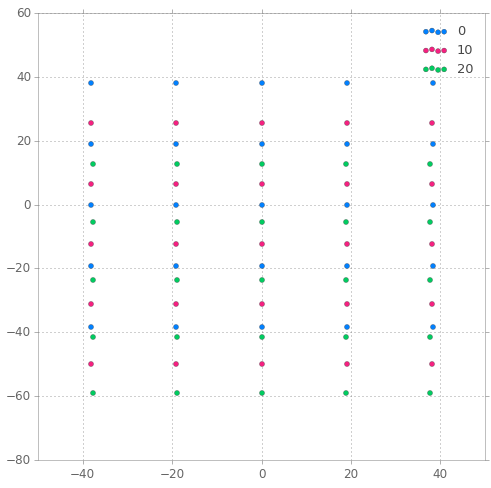

In [24]:
# basic test of the function
x_o = np.array([400., 200., 0.0, -200, -400])
y_o = np.array([400., 200., 0.0, -200, -400])
z_o = 2098.823529
zdash_o = 128.410514
mp=0.8225806452000001

alphaL= [0, 10, 20] 
x_o_grid, y_o_grid = np.meshgrid(x_o, y_o)

colCyc = ['#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF']
fig, ax = plt.subplots(1,1, figsize=(8,8))

for i, each in enumerate(alphaL):
    xdash_o_grid = get_xdash_o(x_o_grid, z_o, zdash_o, each, mp)
    ydash_o_grid = get_ydash_o(y_o_grid, z_o, zdash_o, each, mp)
    ax.scatter(xdash_o_grid, ydash_o_grid, c=colCyc[i], s=25, lw=0.3)
ax.grid()
ax.legend(['0', '10', '20'])
plt.show()

In [75]:
xdash_o_grid[0][0]

-37.782451934881607

In [77]:
xdash_o_grid[0][-1]

37.782451934881607

In [78]:
xdash_o_grid[-1][-0]

-37.782451934881607

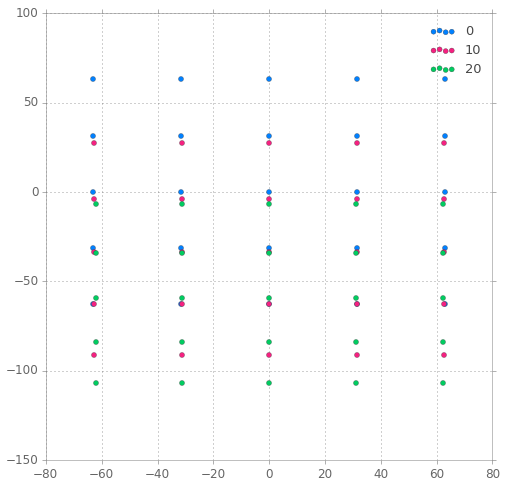

In [80]:
x_o = np.array([400., 200., 0.0, -200, -400])
y_o = np.array([400., 200., 0.0, -200, -400])
z_o = 2098.823529
zdash_o = 128.410514
mp=0.5

alphaL= [0, 10, 20] 
x_o_grid, y_o_grid = np.meshgrid(x_o, y_o)

colCyc = ['#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF']
fig, ax = plt.subplots(1,1, figsize=(8,8))

for i, each in enumerate(alphaL):
    xdash_o_grid = get_xdash_o(x_o_grid, z_o, zdash_o, each, mp)
    ydash_o_grid = get_ydash_o(y_o_grid, z_o, zdash_o, each, mp)
    ax.scatter(xdash_o_grid, ydash_o_grid, c=colCyc[i], s=25, lw=0.3)
ax.grid()
ax.legend(['0', '10', '20'])
plt.show()

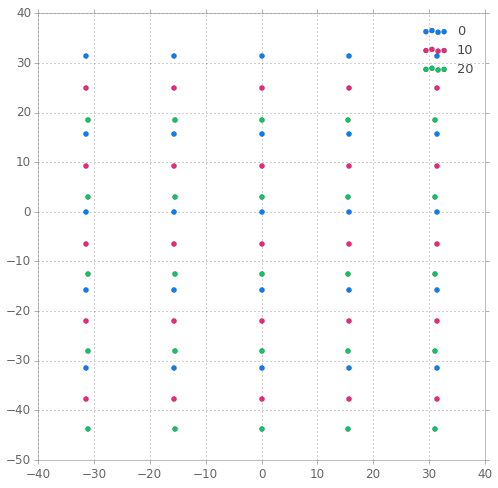

In [81]:
x_o = np.array([400., 200., 0.0, -200, -400])
y_o = np.array([400., 200., 0.0, -200, -400])
z_o = 2098.823529
zdash_o = 128.410514
mp=1.0

alphaL= [0, 10, 20] 
x_o_grid, y_o_grid = np.meshgrid(x_o, y_o)

colCyc = ['#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF']
fig, ax = plt.subplots(1,1, figsize=(8,8))

for i, each in enumerate(alphaL):
    xdash_o_grid = get_xdash_o(x_o_grid, z_o, zdash_o, each, mp)
    ydash_o_grid = get_ydash_o(y_o_grid, z_o, zdash_o, each, mp)
    ax.scatter(xdash_o_grid, ydash_o_grid, c=colCyc[i], s=25, lw=0.3)
ax.grid()
ax.legend(['0', '10', '20'])
plt.show()